In [15]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, normalize
from timeit import default_timer as timer
import matplotlib.pyplot as plt

def load_data(filename):
    df = pd.read_csv("./data/" + filename)
    print(df.shape)
    if filename == "falldeteciton.csv":   
        X = df.iloc[:,1:]
        y = df.iloc[:,0] 
        print(sorted(df['ACTIVITY'].unique()))
    else:
        X = df.iloc[:,:-1]
        y = df.iloc[:,-1]
        print(sorted(df['target_class'].unique()))
    return X, y

def split_data(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=test_size)
    return X_train, X_test, y_train, y_test

def normalize_data(X_train, X_test):
    sc = StandardScaler()
    X_train_scale = sc.fit_transform(X_train)
    X_test_scale = sc.transform(X_test)
    return X_train_scale, X_test_scale

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#X, y = load_data("falldeteciton.csv")
#X, y = load_data("pulsar_stars.csv")
#print(X.head())
#print(y.head())

## Part 1: Clustering Algorithms 

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

def kmeans_cluster(X,y,title):

    k_range = range(2, 11)
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []

    for k in k_range:
        print(k)
        start = timer()
        km = KMeans(n_clusters=k,n_init=10,random_state=10,n_jobs=-1).fit(X)
        end = timer()
        train_times.append(end - start)
        sil_scores.append(sil_score(X, km.labels_))
        #y_mode_vote = cluster_predictions(y,km.labels_)
        #f1_scores.append(f1_score(y, y_mode_vote))
        #homo_scores.append(homogeneity_score(y, km.labels_))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for KMeans: '+ title)
    plt.show()
   
    # plot homogeneity scores
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #ax.plot(kclusters, homo_scores)
    #plt.grid(True)
    #plt.xlabel('No. Clusters')
    #plt.ylabel('Homogeneity Score')
    #plt.title('Homogeneity Scores KMeans: '+ title)
    #plt.show()

(17898, 9)
[0, 1]
2
3
4
5
6
7
8
9
10


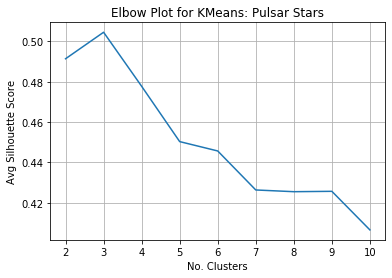

In [19]:
X, y = load_data("pulsar_stars.csv")
X = normalize(X)
kmeans_cluster(X,y,'Pulsar Stars')